In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/AIN311 - Project/dataset_raw.zip'

# Specify the destination folder where you want to extract the contents
extract_folder = '/content'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [4]:
main_folder = "dataset_raw"
classes = os.listdir(main_folder)
classes.sort()

* The downloaded dataset have no duplicates.

# **Split train, validation, and test sets**

In [5]:
X = []
y = []

# Read images and labels
# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        X.append(filename)
        y.append(class_folder)

X = np.array(X)
y = np.array(y)

# Encode y array
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split train and test sets
from sklearn.model_selection import train_test_split

# The resulting splits are stratified, which means class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=42, shuffle=True, stratify=y_train)

* The distribution of classes are preserved in resulting train and test sets, with using `stratify=y` and `stratify=y_train` parameter.

In [6]:
''' import shutil
shutil.rmtree('dataset') '''


" import shutil\nshutil.rmtree('dataset') "

### **Save Train, Validation, and Test Splits**

In [7]:
import shutil

# Create folders if does not exist
if not os.path.exists("dataset/train"):
    os.makedirs("dataset/train")
if not os.path.exists("dataset/test"):
    os.makedirs("dataset/test")
if not os.path.exists("dataset/val"):
    os.makedirs("dataset/val")

# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)

        if filename in X_train:
            shutil.copy(image_path, f"dataset/train/{filename}")

        elif filename in X_test:
            shutil.copy(image_path, f"dataset/test/{filename}")

        elif filename in X_val:
            shutil.copy(image_path, f"dataset/val/{filename}")

* The images are saved into location `dataset/train`, `dataset/test`, and `dataset/val`.

### **Class Distributions in the Train and Test Sets**

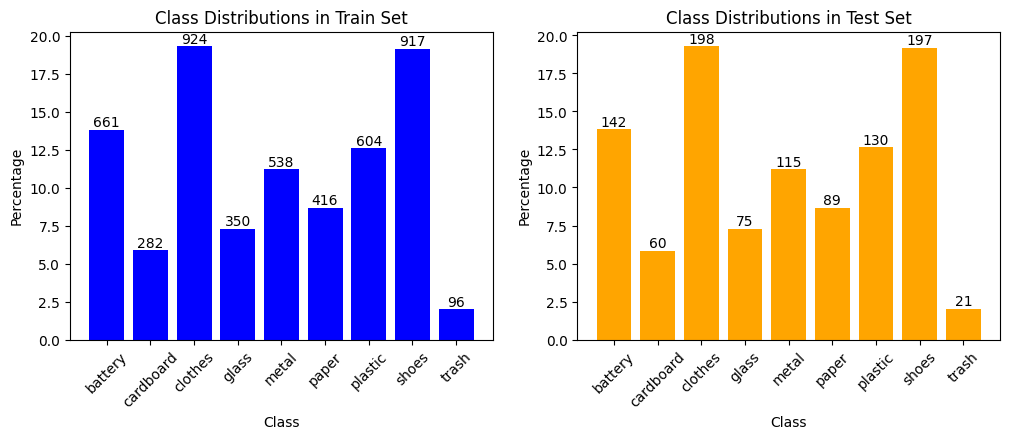

In [8]:
# Count occurrences of each class in y_train and y_test
train_counts = np.bincount(y_train, minlength=len(classes))
test_counts = np.bincount(y_test, minlength=len(classes))

# Convert counts to percentages
train_percentages = (train_counts / len(y_train)) * 100
test_percentages = (test_counts / len(y_test)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot class distribution for training set
bars = ax[0].bar(classes, train_percentages, color='blue')
ax[0].bar(classes, train_percentages, color='blue')
ax[0].set_title('Class Distributions in Train Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage')
ax[0].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the test set
for bar, count in zip(bars, train_counts):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Plot class distribution for testing set
bars = ax[1].bar(classes, test_percentages, color='orange')
ax[1].bar(classes, test_percentages, color='orange')
ax[1].set_title('Class Distributions in Test Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage')
ax[1].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the test set
for bar, count in zip(bars, test_counts):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

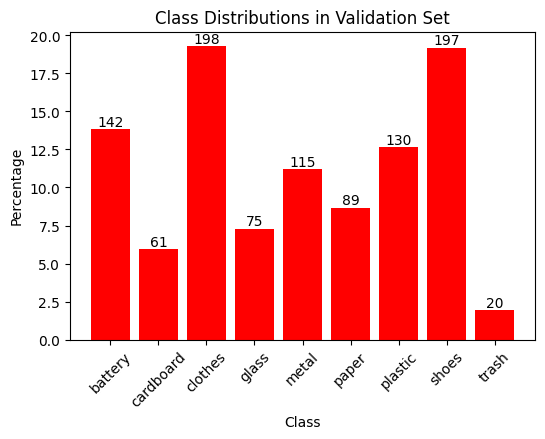

In [9]:
# Count occurrences of each class in y_val
val_counts = np.bincount(y_val, minlength=len(classes))

# Convert counts to percentages
val_percentages = (val_counts / len(y_val)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# Plot class distribution for validation set
bars = ax.bar(classes, val_percentages, color='red')
ax.bar(classes, val_percentages, color='red')
ax.set_title('Class Distributions in Validation Set')
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the test set
for bar, count in zip(bars, val_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

* The distribution of classes are same with the orginal dataset.

# **Data Augmentation on the Train Set**

In [10]:
from keras.preprocessing import image
import tensorflow as tf

train_data_dir = 'dataset/train'

# Augmentation parameters
augmentation_datagen = image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
)

# Iterate through each file in the training directory
for filename in os.listdir(train_data_dir):
    # Load the image
    img_path = os.path.join(train_data_dir, filename)
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Perform data augmentation and save augmented images
    i = 0
    for batch in augmentation_datagen.flow(img, batch_size=1):
        augmented_img = tf.keras.utils.img_to_array(batch[0])
        save_path = os.path.join(train_data_dir, f'aug_{i}_{filename}')

        pil_img = Image.fromarray(augmented_img.astype(np.uint8)).convert('RGB')
        pil_img.save(save_path)

        i += 1
        # Generate three augmented images
        if i >= 3:
            break

### **Read the Splitted Dataset**

In [13]:
import io_functions

X_train, y_train = io_functions.read_data("dataset/train", flatten_controller=False, image_size=128)
X_test, y_test = io_functions.read_data("dataset/test", flatten_controller=False, image_size=128)
X_val, y_val = io_functions.read_data("dataset/val", flatten_controller=False, image_size=128)

In [ ]:
dataset_path = '/content/drive/MyDrive/AIN311 - Project/dataset_npy_new'

# Load training data
X_train_loaded = np.load(dataset_path + "X_train.npy")
y_train_loaded = np.load(dataset_path + "X_train.npy")

# Load test data
X_test_loaded = np.load(dataset_path + "X_test.npy")
y_test_loaded = np.load(dataset_path + "y_test.npy")

# Load validation data
X_val_loaded = np.load(dataset_path + "X_val.npy")
y_val_loaded = np.load(dataset_path + "y_val.npy")


### **Number of Images After the Data Augmentation**

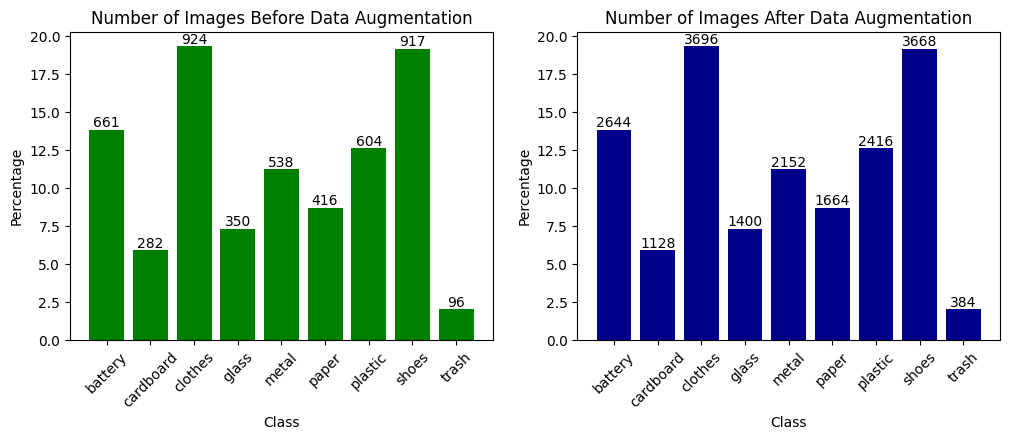

Old Train Set Size = 4788
New Train Set Size = 19152
Test Set Size = 1027


In [15]:
# Count occurrences of each class in y_train and y_test
train_counts_new = np.bincount(y_train, minlength=len(classes))

# Convert counts to percentages
train_percentages_new = (train_counts_new / len(y_train)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot class distribution for old training set
bars = ax[0].bar(classes, train_percentages, color='green')
ax[0].bar(classes, train_percentages, color='green')
ax[0].set_title('Number of Images Before Data Augmentation')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage')
ax[0].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the old training set
for bar, count in zip(bars, train_counts):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Plot class distribution for new training set
bars = ax[1].bar(classes, train_percentages_new, color='darkblue')
ax[1].bar(classes, train_percentages_new, color='darkblue')
ax[1].set_title('Number of Images After Data Augmentation')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage')
ax[1].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the new training set
for bar, count in zip(bars, train_counts_new):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

print("Old Train Set Size =", np.sum(train_counts))
print("New Train Set Size =", np.sum(train_counts_new))
print("Test Set Size =", np.sum(test_counts))

### **Shuffle the arrays**

In [16]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


In [24]:
y_train = LabelBinarizer().fit(range(max(y_train)+1)).transform(y_train)
y_test = LabelBinarizer().fit(range(max(y_test)+1)).transform(y_test)
y_val = LabelBinarizer().fit(range(max(y_val)+1)).transform(y_val)

In [17]:
dataset_path = '/content/drive/MyDrive/AIN311 - Project/dataset_npy_new/'

np.save(dataset_path + "X_train", X_train)
np.save(dataset_path + "X_train", y_train)

np.save(dataset_path + "X_test", X_test)
np.save(dataset_path + "y_test", y_test)

np.save(dataset_path + "X_val", X_val)
np.save(dataset_path + "y_val", y_val)

* Our dataset is now prepared for utilization in machine learning algorithms.

# **Applying Deep Learning Algorithms with Validation Set**

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import gdown
import zipfile
import os
import pandas as pd
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from io_functions import read_data

## **CNN From Scratch**

In [28]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid', activation='relu', input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(9, activation='softmax'))

    return model

In [29]:
model = create_model()

optimizer = Adam()
loss_func = categorical_crossentropy

model = create_model()

model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=15, restore_best_weights=True)

model.compile(loss = loss_func, optimizer = optimizer, metrics = CategoricalAccuracy())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 63, 63, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 31, 31, 96)        153696    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 128)       110720    
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 64)       

In [30]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
599/599 [==============================] - 6s 7ms/step - loss: 2.3132 - categorical_accuracy: 0.3369 - val_loss: 1.5888 - val_categorical_accuracy: 0.4109
Epoch 2/100
599/599 [==============================] - 3s 6ms/step - loss: 1.5001 - categorical_accuracy: 0.4472 - val_loss: 1.4378 - val_categorical_accuracy: 0.4742
Epoch 3/100
599/599 [==============================] - 4s 6ms/step - loss: 1.3723 - categorical_accuracy: 0.4920 - val_loss: 1.2453 - val_categorical_accuracy: 0.5706
Epoch 4/100
599/599 [==============================] - 3s 6ms/step - loss: 1.2627 - categorical_accuracy: 0.5415 - val_loss: 1.2465 - val_categorical_accuracy: 0.5336
Epoch 5/100
599/599 [==============================] - 3s 6ms/step - loss: 1.1901 - categorical_accuracy: 0.5690 - val_loss: 1.1984 - val_categorical_accuracy: 0.5881
Epoch 6/100
599/599 [==============================] - 3s 6ms/step - loss: 1.1010 - categorical_accuracy: 0.6014 - val_loss: 1.1404 - val_categorical_accuracy: 0.595

In [31]:
def plot_loss_acc(history):

    # Plot train-validation losses
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    epochs = range(1, len(history.history['loss']) + 1)
    ax[0].plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    ax[0].plot(epochs, history.history['val_loss'], marker='o', label='Validation Loss')
    ax[0].set_title('Train and Validation Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    ax[0].legend(loc='upper right')

    # Plot train-validation accuracies
    ax[1].plot(epochs, history.history['categorical_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(epochs, history.history['val_categorical_accuracy'], marker='o', label='Validation Accuracy')
    ax[1].set_title('Train and Validation Accuracies Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

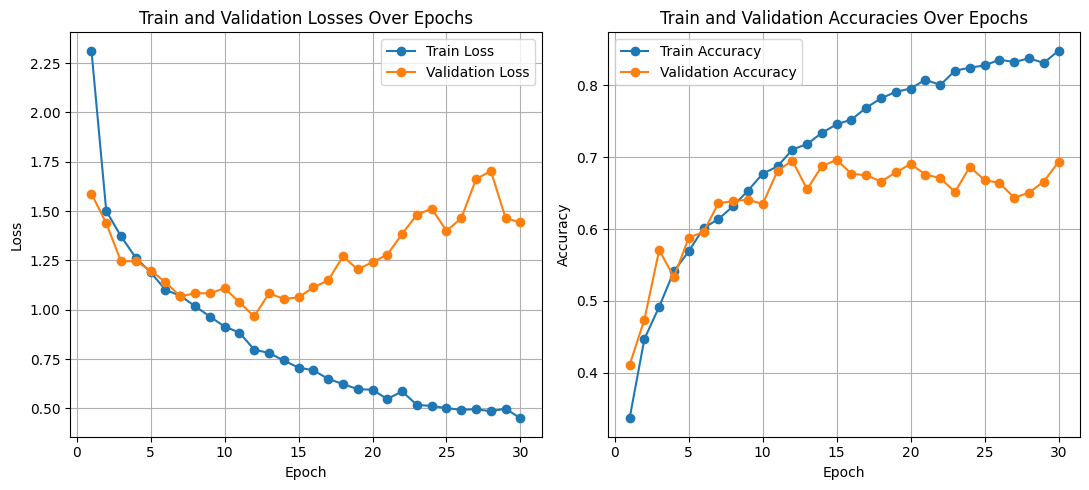

In [32]:
plot_loss_acc(history)

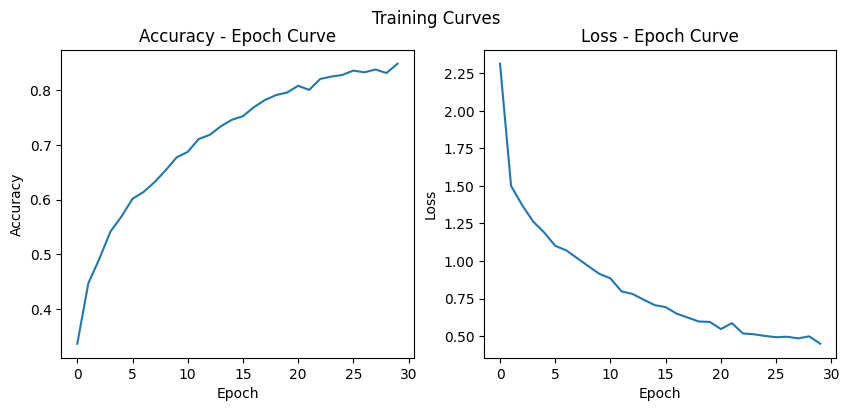

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Training Curves')

ax1.plot(history.history["categorical_accuracy"])
ax1.set_title("Accuracy - Epoch Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss - Epoch Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.savefig("curves")

33/33 [==============================] - 0s 2ms/step


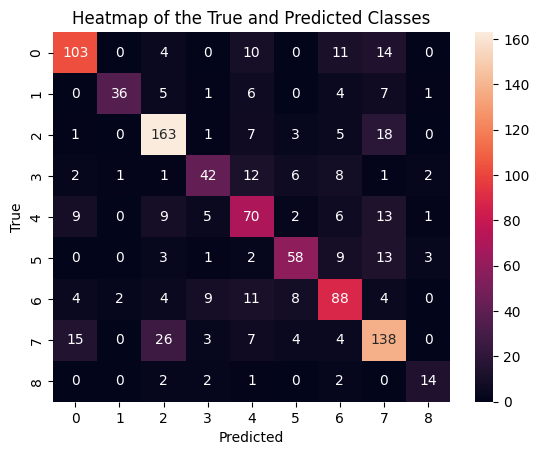

In [34]:
y_pred = model.predict(X_test)
y_pred = np.argmax (y_pred, axis = 1)

y_testt = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_testt, y_pred)

ax = sns.heatmap(conf_matrix, annot=True, fmt='.3g')

plt.title("Heatmap of the True and Predicted Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confMatrix")

In [35]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

df = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])
df = pd.concat([df, pd.DataFrame([{'Train Accuracy': train_accuracy,
                                   'Validation Accuracy': validation_accuracy,
                                   'Test Accuracy': test_accuracy}])], ignore_index=True)
df.index += 1
display(df)

33/33 [==============================] - 0s 3ms/step - loss: 1.1355 - categorical_accuracy: 0.6933


,Train Accuracy,Validation Accuracy,Test Accuracy
1,0.861424,0.696203,0.693281


## **VGG-16 Transfer Learning**

In [36]:
# Function to create vgg model with edited last layer
num_classes = 9
def create_model_vgg16_last_3_fc(name):
    # Get the VGG16 model
    vgg = VGG16(weights='imagenet', include_top=True)

    # Remove the last layer
    vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

    # Create a new FC layer for prediction
    prediction_layer = layers.Dense(num_classes, activation='softmax', name='prediction_new')(vgg.output)

    # Combine VGG16 with prediction layer
    vgg = Model(inputs=vgg.input, outputs=prediction_layer, name=name)

    return vgg

def create_model_vgg16_last_3_fc(name):
    # Get the VGG16 model
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    for layer in vgg.layers:
      layer.trainable = False

    # FC 1
    x = layers.Flatten(name="flatten")(vgg.output)
    x = x = layers.Dense(4096, activation='relu', name="fc1")(x)

    # FC 2
    x = layers.Dense(4096, activation='relu', name="fc2")(x)

    # Output
    output_layer = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

    # Create the model
    model = models.Model(inputs=vgg.input, outputs=output_layer, name=name)

    return model

In [37]:
# Create model
vgg_1 = create_model_vgg16_last_3_fc("vgg16_1")
vgg_1.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

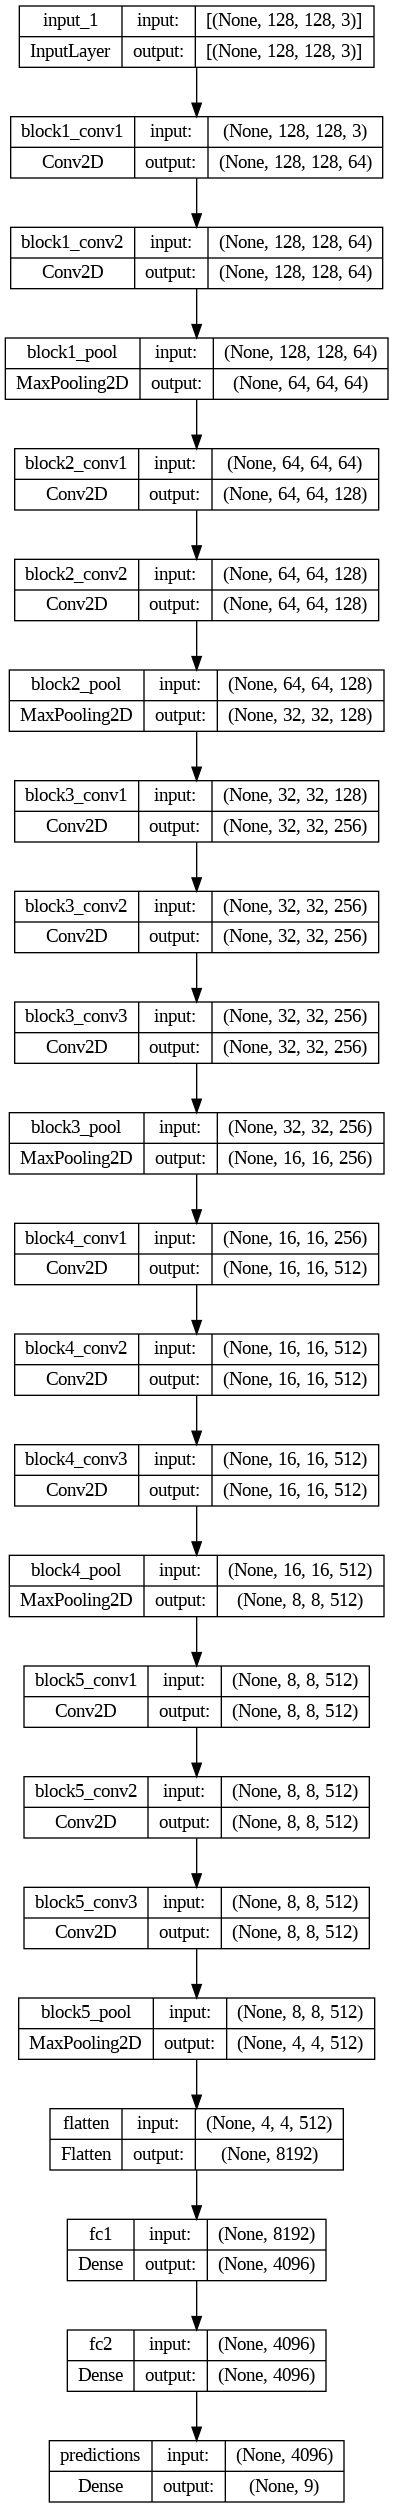

In [38]:
plot_model(vgg_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
# Compile the model
vgg_1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=15, restore_best_weights=True)

# Train
history_vgg_1 = vgg_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
599/599 [==============================] - 15s 21ms/step - loss: 2.1480 - categorical_accuracy: 0.7987 - val_loss: 0.5022 - val_categorical_accuracy: 0.8812
Epoch 2/100
599/599 [==============================] - 11s 19ms/step - loss: 0.2768 - categorical_accuracy: 0.9180 - val_loss: 0.6886 - val_categorical_accuracy: 0.8510
Epoch 3/100
599/599 [==============================] - 11s 19ms/step - loss: 0.2414 - categorical_accuracy: 0.9391 - val_loss: 0.7621 - val_categorical_accuracy: 0.8647
Epoch 4/100
599/599 [==============================] - 11s 19ms/step - loss: 0.1906 - categorical_accuracy: 0.9563 - val_loss: 0.9642 - val_categorical_accuracy: 0.8617
Epoch 5/100
599/599 [==============================] - 11s 19ms/step - loss: 0.1561 - categorical_accuracy: 0.9659 - val_loss: 1.2640 - val_categorical_accuracy: 0.8617
Epoch 6/100
599/599 [==============================] - 11s 19ms/step - loss: 0.1876 - categorical_accuracy: 0.9664 - val_loss: 1.2063 - val_categorical_acc

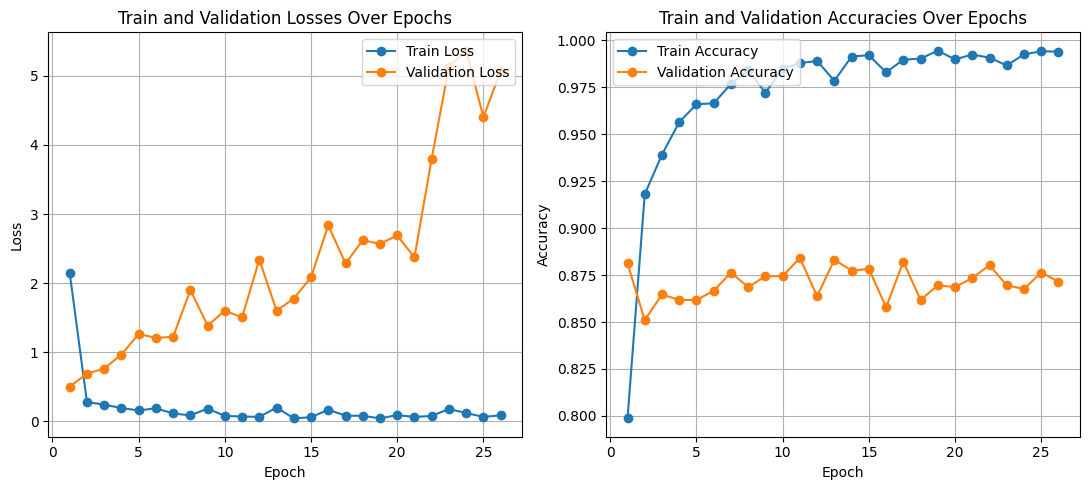

In [40]:
plot_loss_acc(history_vgg_1)

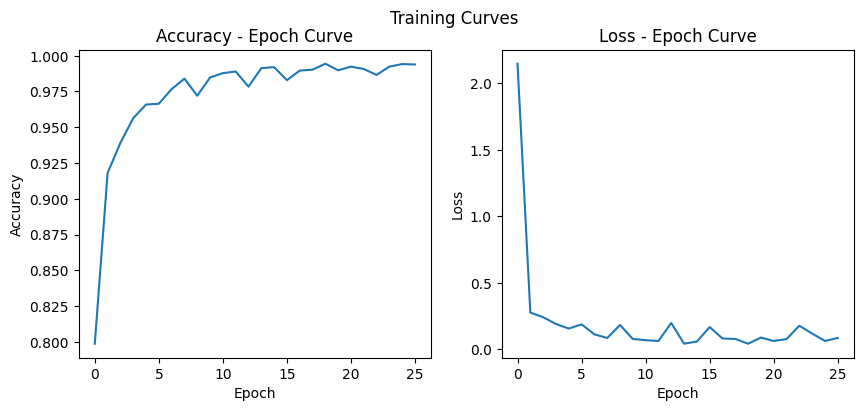

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Training Curves')

ax1.plot(history_vgg_1.history["categorical_accuracy"])
ax1.set_title("Accuracy - Epoch Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

ax2.plot(history_vgg_1.history["loss"])
ax2.set_title("Loss - Epoch Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.savefig("curves")

33/33 [==============================] - 1s 13ms/step


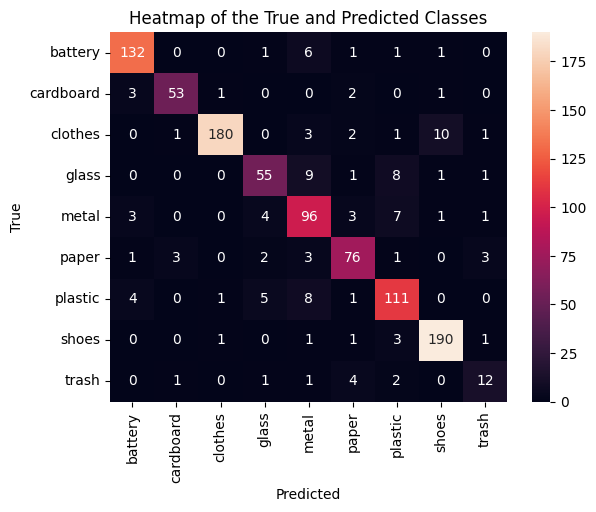

In [42]:
class_labels = ['battery', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
y_pred = vgg_1.predict(X_test)
y_pred = np.argmax (y_pred, axis = 1)

y_testt = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_testt, y_pred)

ax = sns.heatmap(conf_matrix, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels)

plt.title("Heatmap of the True and Predicted Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confMatrix")

33/33 [==============================] - 0s 12ms/step


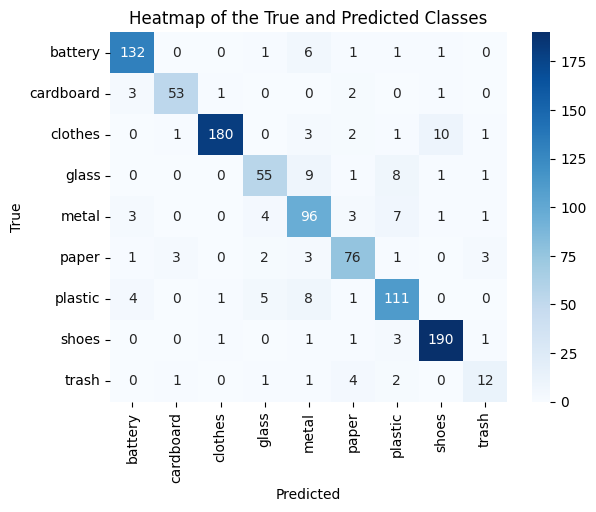

In [46]:
class_labels = ['battery', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
y_pred = vgg_1.predict(X_test)
y_pred = np.argmax (y_pred, axis = 1)

y_testt = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_testt, y_pred)

ax = sns.heatmap(conf_matrix, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')

plt.title("Heatmap of the True and Predicted Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confMatrix")

In [43]:
train_loss, train_accuracy = vgg_1.evaluate(X_train, y_train)
validation_loss, validation_accuracy = vgg_1.evaluate(X_val, y_val)
test_loss, test_accuracy = vgg_1.evaluate(X_test, y_test)

df = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])
df = pd.concat([df, pd.DataFrame([{'Train Accuracy': train_accuracy,
                                   'Validation Accuracy': validation_accuracy,
                                   'Test Accuracy': test_accuracy}])], ignore_index=True)
df.index += 1
display(df)

33/33 [==============================] - 0s 14ms/step - loss: 1.4001 - categorical_accuracy: 0.8812


,Train Accuracy,Validation Accuracy,Test Accuracy
1,0.993212,0.884129,0.881207


# **Applying Classical Machine Learning Algorithms with Validation Set**

In [47]:
import io_functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## **Apply HOG Feature Extraction**

**1)** Reshape to original shape 128x128x3

**2)** Convert to grayscale

**3)** Compute HOG features

**4)** Apply L2 normalization to each vector such that Euclidean norm (L2 norm) is equal to 1

In [48]:
from skimage import color, feature

# Compute HOG Features
def compute_hog_features(rgb_image):

    # Convert RGB to grayscale
    image_gray = color.rgb2gray(rgb_image)

    # Compute HOG features
    hog_features = feature.hog(image_gray, block_norm='L2-Hys', visualize=False)

    return hog_features

In [50]:
# Apply the HOG feature extraction to all images
X_train = np.array([compute_hog_features(rgb_image) for rgb_image in X_train])
X_test = np.array([compute_hog_features(rgb_image) for rgb_image in X_test])
X_val = np.array([compute_hog_features(rgb_image) for rgb_image in X_val])

# Normalize pixel values
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
X_val = preprocessing.normalize(X_val)

In [51]:
def evaluate(model):
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)

    # Evaluate accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    val_accuracy = accuracy_score(y_val, y_pred_val)

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Validation Accuracy:", val_accuracy)

    return train_accuracy, test_accuracy, val_accuracy

In [52]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
y_val = np.argmax(y_val, axis=1)

## **Logistic Regression**

In [54]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', max_iter=500, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

logreg_train_acc, logreg_test_acc, logreg_val_acc = evaluate(logreg)

Train Accuracy: 0.5879803675856308
Test Accuracy: 0.5462512171372931
Validation Accuracy: 0.5744888023369036


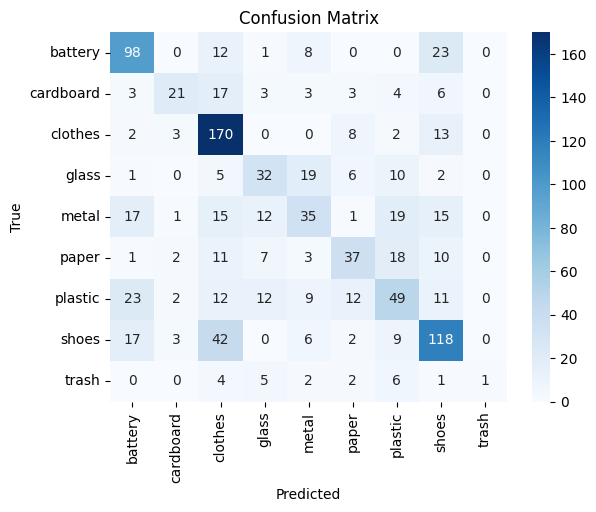

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
class_labels = ['battery', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# Visualize the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Random Forest**

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_train_acc, rf_test_acc, rf_val_acc = evaluate(rf)

Train Accuracy: 1.0
Test Accuracy: 0.5481986368062317
Validation Accuracy: 0.5326192794547225


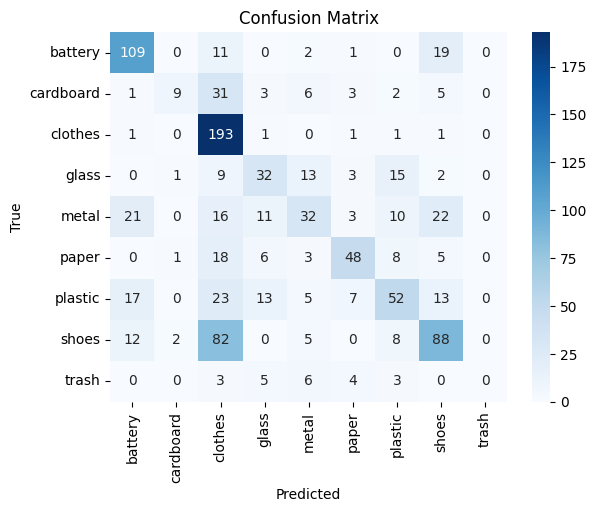

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_labels = ['battery', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# Visualize the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Weighted KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define a range of k values
k_values = np.arange(1, 21)
train_accuracies = []
test_accuracies = []
val_accuracies = []

# Iterate over different k values
for k in k_values:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train)

    knn_train_acc, knn_test_acc, knn_val_acc = evaluate(knn)
    train_accuracies.append(knn_train_acc)
    test_accuracies.append(knn_test_acc)
    val_accuracies.append(knn_val_acc)

# Plot the accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('k-NN Accuracy Curve')
plt.legend()
plt.show()

1
